Useful links:

https://medium.com/@imabhi1216/fine-tuning-a-vision-transformer-vit-model-with-a-custom-dataset-37840e4e9268#f0a3

https://www.kaggle.com/code/luthei/vit-vs-cnn-on-wikiart/notebook#3.2-Test-Accuracy



In [3]:
# !pip install datasets

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Dataset
https://huggingface.co/datasets/huggan/wikiart

In [6]:
def plot_histogram(data, title):
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=range(min(data), max(data) + 2), edgecolor='black')
    plt.title(title)
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.show()

In [7]:
dataset = load_dataset("huggan/wikiart", split="train")

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/45 [00:00<?, ?it/s]

In [8]:
print(f"Total number of records: {len(dataset)}")
print(f"Number of columns: {len(dataset.column_names)}")
print(dataset.column_names)

Total number of records: 81444
Number of columns: 4
['image', 'artist', 'genre', 'style']


In [9]:
unique_genres = set(dataset['genre'])
print(f"Number of genres: {unique_genres.__len__()}")
print(f"Unique genres: {unique_genres}")

Number of genres: 11
Unique genres: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


In [10]:
unique_style = set(dataset['style'])
print(f"Number of styles: {unique_style.__len__()}")
print(f"Unique styles: {unique_style}")

Number of styles: 27
Unique styles: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


We will be using only 2 columns: image and genre

In [11]:
df = pd.DataFrame(dataset['genre'], columns=['genre'])

genre_counts = df['genre'].value_counts()
sorted_counts = genre_counts.sort_index(ascending=True)

sorted_counts_df = pd.DataFrame(sorted_counts).reset_index()
sorted_counts_df.columns = ['genre', 'count']
#sorted_counts_df.style.hide_index()


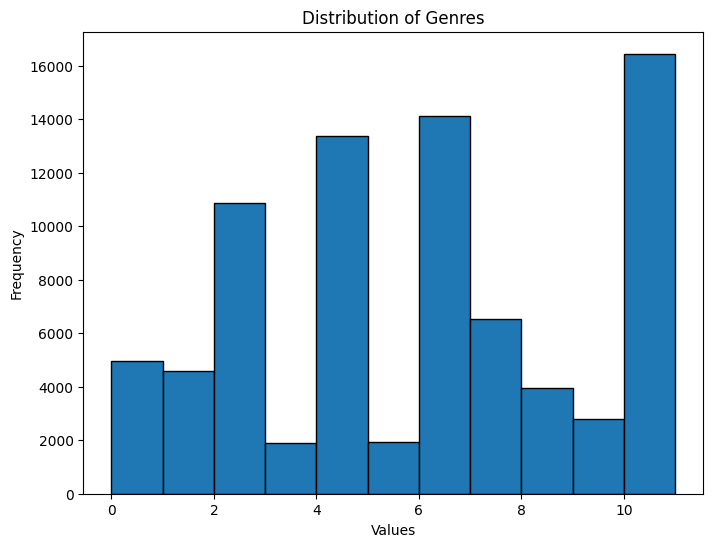

In [12]:
plot_histogram(dataset['genre'], "Distribution of Genres")

Concerning disproportion  in distribution of genres. This may negatively impact the classification results. 

In [13]:
list_of_images = []
for genre in unique_genres:
    for i in range(len(dataset)):
        if dataset[i]['genre'] == genre:
            list_of_images.append(dataset[i]['image'])
            break

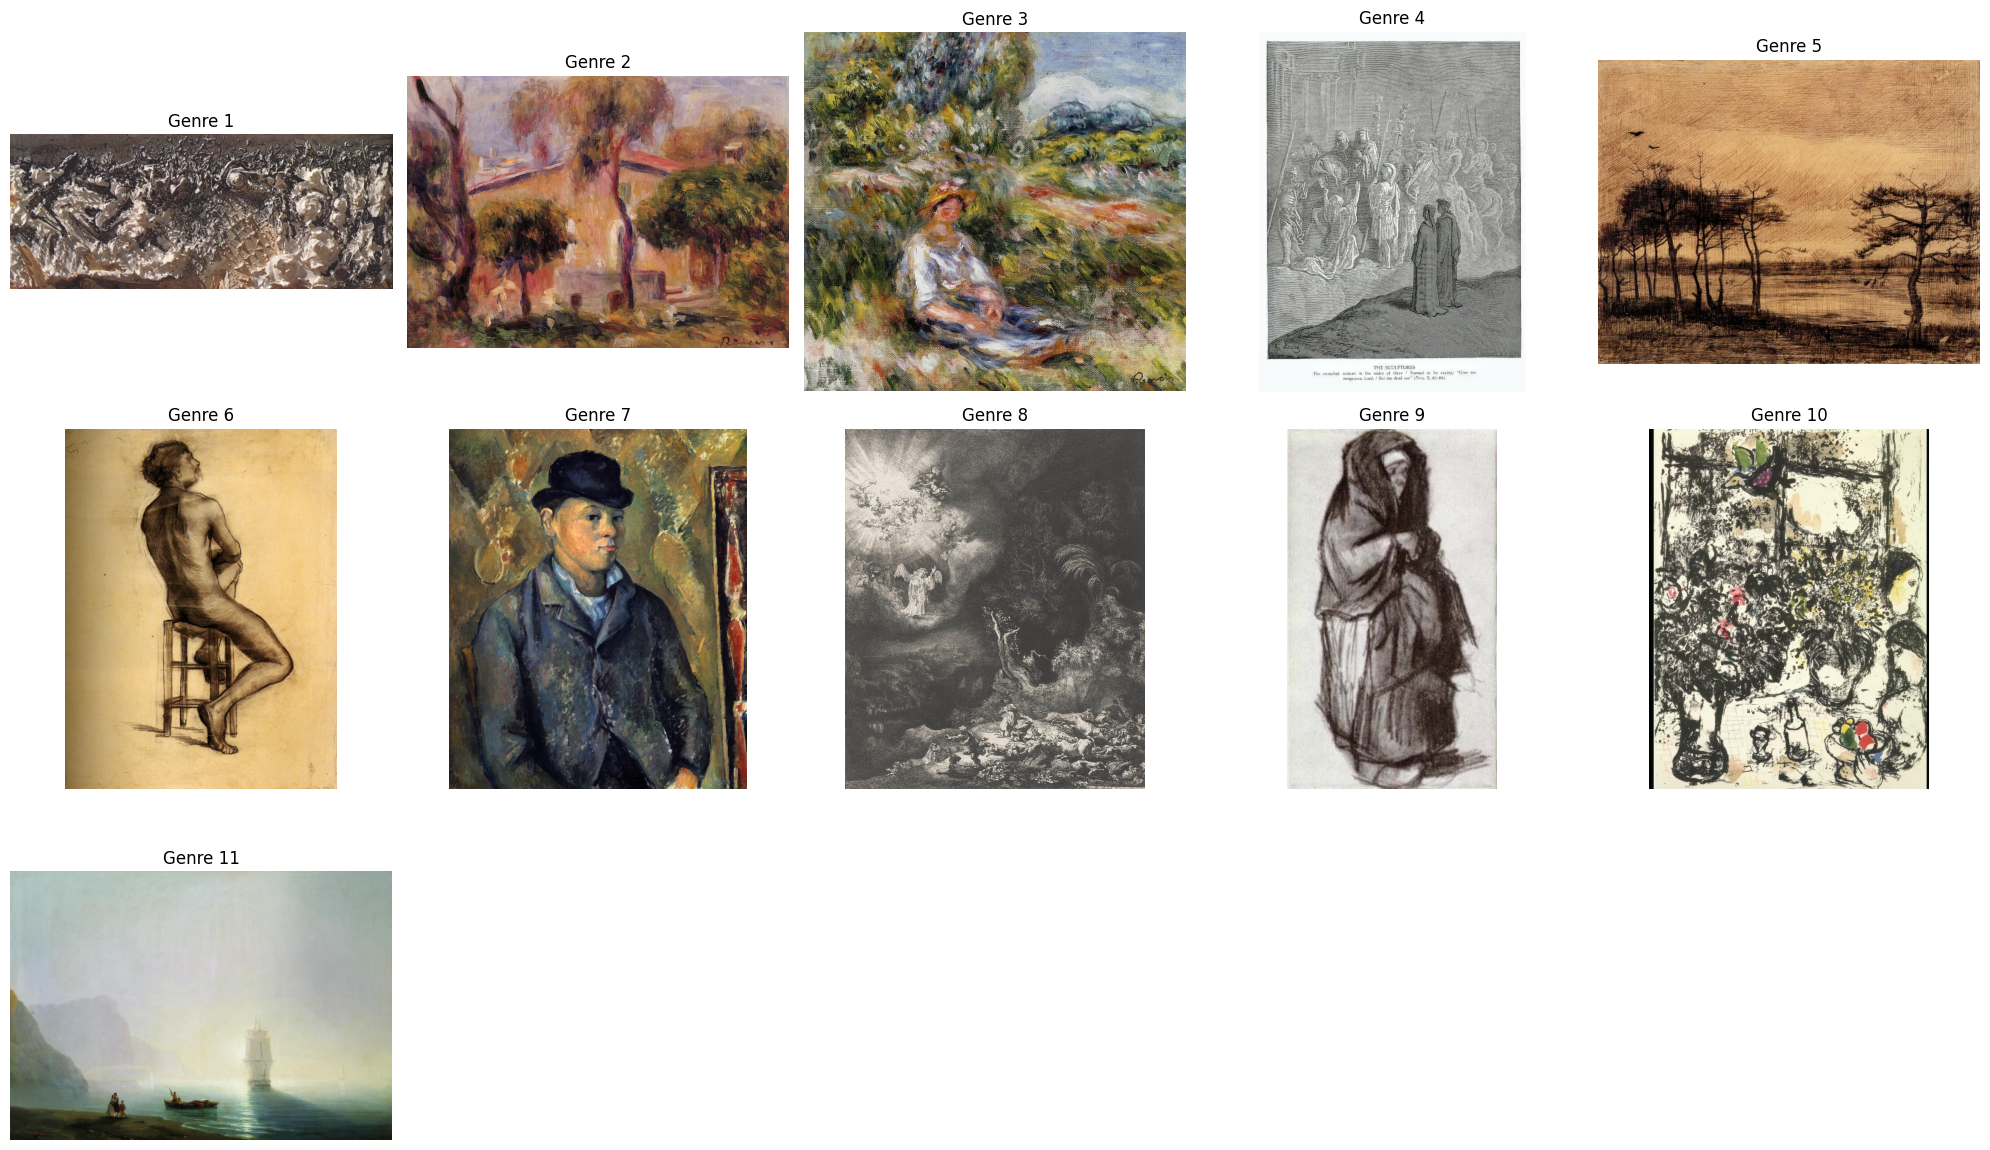

In [14]:
plt.figure(figsize=(20, 20))
for i in range(len(list_of_images)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(list_of_images[i])
    plt.title(f"Genre {i + 1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## ViT

In [15]:
from transformers import ViTImageProcessor, ViTForImageClassification, Trainer, TrainingArguments

In [16]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')


In [17]:
from collections import Counter
import random

# Count samples per (genre, style)
counter = Counter(dataset['style'])
min_count = min(counter.values())

# Group indices by (genre, style)
grouped_indices = {}
for idx, (s) in enumerate(dataset['style']):
    grouped_indices.setdefault(s, []).append(idx)

# Sample min_count indices from each group
selected_indices = []
for indices in grouped_indices.values():
    selected_indices.extend(random.sample(indices, min_count))

# Select balanced subset
dataset = dataset.select(selected_indices)
print(f"Balanced dataset size: {len(dataset)}")

Balanced dataset size: 2646


Encoding genre labels

In [18]:
genres = list(set(dataset['genre']))
styles = list(set(dataset['style']))

label2id = {g: i for i, g in enumerate(genres)}
id2label = {i: g for g, i in label2id.items()}

style2id = {s: i for i, s in enumerate(styles)}
id2style = {i: s for s, i in style2id.items()}

def encode_labels(example):
    example['genre_label'] = label2id[example['genre']]
    example['style_label'] = style2id[example['style']]
    return example

dataset = dataset.map(encode_labels)

Map:   0%|          | 0/2646 [00:00<?, ? examples/s]

Preprocessing images

In [20]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

def preprocess(example):
    inputs = processor(images=example['image'], return_tensors="pt")
    example['pixel_values'] = inputs['pixel_values'][0]
    return example

dataset = dataset.map(preprocess)

Map:   0%|          | 0/2646 [00:00<?, ? examples/s]

Splitting dataset into train and test sets

In [21]:
def collate_fn(examples):
    pixel_values = torch.stack([
        torch.tensor(example["pixel_values"]) if not isinstance(example["pixel_values"], torch.Tensor)
        else example["pixel_values"]
        for example in examples
    ])
    genre_labels = torch.tensor([example["genre_label"] for example in examples])
    style_labels = torch.tensor([example["style_label"] for example in examples])
    return {
        "pixel_values": pixel_values,
        "genre_labels": genre_labels,
        "style_labels": style_labels
    }

In [22]:
split = dataset.train_test_split(test_size=0.2)
train_dataset = split['train']
eval_dataset = split['test']

In [23]:
import torch
import torch.nn as nn
from transformers import ViTModel

class ViTMultiTask(nn.Module):
    def __init__(self, num_genres, num_styles):
        super().__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        hidden_size = self.vit.config.hidden_size
        self.genre_head = nn.Linear(hidden_size, num_genres)
        self.style_head = nn.Linear(hidden_size, num_styles)

    def forward(self, pixel_values, **kwargs):
        outputs = self.vit(pixel_values=pixel_values)
        pooled = outputs.pooler_output
        genre_logits = self.genre_head(pooled)
        style_logits = self.style_head(pooled)
        return genre_logits, style_logits

In [24]:
# Initialize the ViT model with your genre classes
model = ViTMultiTask(num_genres=len(genres), num_styles=len(styles))
model.to(device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTMultiTask(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn):

In [46]:
import evaluate
from sklearn.metrics import top_k_accuracy_score

accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    top3_accuracy = top_k_accuracy_score(labels, logits, k=3)
    top5_accuracy = top_k_accuracy_score(labels, logits, k=5)
    f1 = f1_metric.compute(predictions=preds, references=labels, average='macro')
    return {
        **accuracy,
        'top3_accuracy': top3_accuracy,
        'top5_accuracy': top5_accuracy,
        **f1,
    }

In [47]:

class MultiTaskTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        pixel_values = inputs["pixel_values"].to(model.vit.device)
        genre_labels = inputs["genre_labels"].to(model.vit.device)
        style_labels = inputs["style_labels"].to(model.vit.device)
        genre_logits, style_logits = model(pixel_values)
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(genre_logits, genre_labels) + loss_fct(style_logits, style_labels)
        return (loss, (genre_logits, style_logits)) if return_outputs else loss

In [51]:

train_args = TrainingArguments(
    output_dir="output-models",
    per_device_train_batch_size=16,
    num_train_epochs=2,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
    eval_strategy='steps',
    metric_for_best_model='eval_avg_accuracy', 
)

In [52]:
trainer = MultiTaskTrainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss,Validation Loss
10,0.710000,No log


KeyError: "The `metric_for_best_model` training argument is set to 'eval_avg_accuracy', which is not found in the evaluation metrics. The available evaluation metrics are: []. Consider changing the `metric_for_best_model` via the TrainingArguments."

In [15]:
outputs = trainer.predict(eval_dataset)
print(outputs.metrics)

{'test_loss': 0.919725775718689, 'test_runtime': 38.4688, 'test_samples_per_second': 10.398, 'test_steps_per_second': 1.3}


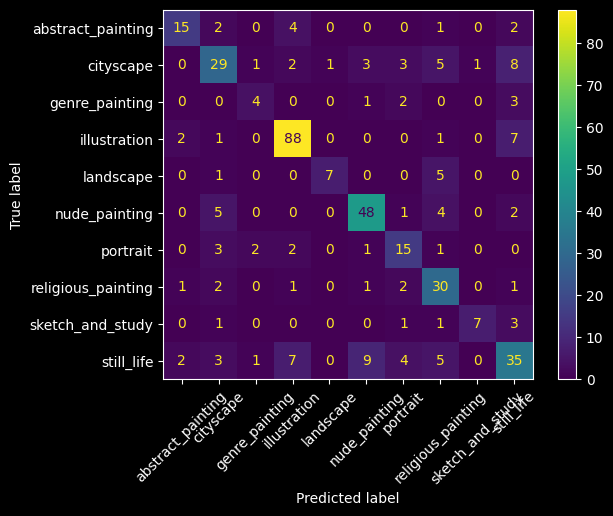

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.style.use('dark_background')

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_dataset.features["genre"].names
cm = confusion_matrix(y_true, y_pred)
if len(labels) != cm.shape[0]:
    labels = labels[:cm.shape[0]]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [32]:
from sklearn.metrics import classification_report

target_names = id2label.values()

print(classification_report(y_true, y_pred, target_names=labels))

                    precision    recall  f1-score   support

 abstract_painting       0.75      0.62      0.68        24
         cityscape       0.62      0.55      0.58        53
    genre_painting       0.50      0.40      0.44        10
      illustration       0.85      0.89      0.87        99
         landscape       0.88      0.54      0.67        13
     nude_painting       0.76      0.80      0.78        60
          portrait       0.54      0.62      0.58        24
religious_painting       0.57      0.79      0.66        38
  sketch_and_study       0.88      0.54      0.67        13
        still_life       0.57      0.53      0.55        66

          accuracy                           0.69       400
         macro avg       0.69      0.63      0.65       400
      weighted avg       0.70      0.69      0.69       400

